In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

torch.manual_seed(1)

In [2]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# define corpus
corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital',
]

In [4]:
# step1. creating vocabulary

# tokenize sentences
def tokenize_corpus(corpus):
    tokens = [sentence.split() for sentence in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)

print("tokenized corpus:", tokenized_corpus)

# word->idx, idx->word
word2idx = {}
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in word2idx:
            word2idx[token] = len(word2idx)

idx2word = {v: k for k, v in word2idx.items()}

print("word2idx:", word2idx)
print("idx2word:", idx2word)

word_vocab_size = len(word2idx)

tokenized corpus: [['he', 'is', 'a', 'king'], ['she', 'is', 'a', 'queen'], ['he', 'is', 'a', 'man'], ['she', 'is', 'a', 'woman'], ['warsaw', 'is', 'poland', 'capital'], ['berlin', 'is', 'germany', 'capital'], ['paris', 'is', 'france', 'capital']]
word2idx: {'he': 0, 'is': 1, 'a': 2, 'king': 3, 'she': 4, 'queen': 5, 'man': 6, 'woman': 7, 'warsaw': 8, 'poland': 9, 'capital': 10, 'berlin': 11, 'germany': 12, 'paris': 13, 'france': 14}
idx2word: {0: 'he', 1: 'is', 2: 'a', 3: 'king', 4: 'she', 5: 'queen', 6: 'man', 7: 'woman', 8: 'warsaw', 9: 'poland', 10: 'capital', 11: 'berlin', 12: 'germany', 13: 'paris', 14: 'france'}


In [5]:
# step 2. Generate pairs (center word - context word)
window_size = 2
idx_pairs = []

# for each sentence
for sentence in tokenized_corpus:
    word_idxs = [word2idx[word] for word in sentence]
    for center_word_pos in range(len(word_idxs)):
        for context_word_pos in range(len(word_idxs)):
            if center_word_pos == context_word_pos:
                pass
            else:
                idx_pairs.append((word_idxs[center_word_pos], word_idxs[context_word_pos]))
idx_pairs = np.array(idx_pairs)
print(idx_pairs.shape)

(84, 2)


## Defining goal
@ We want to predict context, given center word and soma parametrization.

@ We are making P(context | center) close to 0 for all non-existing (context, center) pairs.

In [9]:
# input layer: just the center word encoded in one-hot manner.
def get_one_hot(word_idx, word_vocab_size):
    x = torch.zeros(word_vocab_size).float()
    x[word_idx] = 1.0
    return x

In [10]:
embedding_dim = 5

W1 = torch.randn((embedding_dim, word_vocab_size), requires_grad=True).to(device)
W2 = torch.randn((word_vocab_size, embedding_dim), requires_grad=True).to(device)

num_epochs = 500
lr = 0.01

print(W1)
print(W2)

tensor([[-0.1637, -0.3582, -0.0594, -2.4919,  0.2423,  0.2883, -0.1095,
          0.3126, -0.3417,  0.9473,  0.6223, -0.4481, -0.2856,  0.3880,
         -1.1435],
        [-0.6512, -2.9167, -0.5673, -1.1992, -0.0474, -2.0030, -0.4914,
          1.7086,  0.7913,  0.7282,  0.0571, -0.7092, -0.5262, -1.1042,
         -0.6994],
        [ 0.5580, -0.9059,  1.8364,  1.3245, -0.0705,  0.3470, -0.6537,
          1.5586,  0.4001,  2.4423,  1.4571,  1.7710, -2.0173,  0.4235,
          0.5730],
        [-1.7962, -0.3061, -0.4203,  0.3909,  0.3872,  2.6415, -0.9624,
         -0.2076, -1.3889,  0.0127, -1.8734, -0.9295,  0.2936,  1.6604,
          0.8956],
        [ 0.1675,  0.7514,  2.4142,  1.0206, -0.4405, -1.7342, -1.0257,
          1.5786, -1.1161,  0.7678, -0.5882,  2.1189, -0.5422, -2.4593,
         -0.9502]])
tensor([[-1.1187,  0.7580, -0.4957, -0.1970, -0.0334],
        [ 0.7193,  1.0644, -0.8336, -1.9162, -0.3420],
        [-0.6605,  0.3151,  1.1423,  0.3055, -0.5789],
        [ 0.5644, -

In [11]:
for epoch in range(num_epochs):
    loss_val = 0
    for center, context in idx_pairs:    
        input = get_one_hot(center, word_vocab_size).to(device).float()
        target = torch.from_numpy(np.array([context])).to(device).long()
        w1_out = torch.matmul(W1, input)
        w2_out = torch.matmul(W2, w1_out)

        log_softmax = F.log_softmax(w2_out, dim=0).view(1, -1)
            
        loss = F.nll_loss(log_softmax, target)
        loss_val += loss.item()
        loss.backward()
        
        W1.data -= lr * W1.grad.data
        W2.data -= lr * W2.grad.data
        
        W1.grad.data.zero_()
        W2.grad.data.zero_()
    
    if epoch % 10 == 0:
        print("[%d/%d] loss:%.3f" % (epoch+1, num_epochs, loss_val / float(len(idx_pairs))))
        

[1/500] loss:4.720
[11/500] loss:2.890
[21/500] loss:2.548
[31/500] loss:2.377
[41/500] loss:2.266
[51/500] loss:2.192
[61/500] loss:2.139
[71/500] loss:2.097
[81/500] loss:2.061
[91/500] loss:2.030
[101/500] loss:2.003
[111/500] loss:1.980
[121/500] loss:1.959
[131/500] loss:1.942
[141/500] loss:1.926
[151/500] loss:1.912
[161/500] loss:1.900
[171/500] loss:1.889
[181/500] loss:1.879
[191/500] loss:1.870
[201/500] loss:1.863
[211/500] loss:1.856
[221/500] loss:1.849
[231/500] loss:1.844
[241/500] loss:1.838
[251/500] loss:1.833
[261/500] loss:1.829
[271/500] loss:1.825
[281/500] loss:1.821
[291/500] loss:1.817
[301/500] loss:1.814
[311/500] loss:1.811
[321/500] loss:1.808
[331/500] loss:1.805
[341/500] loss:1.803
[351/500] loss:1.800
[361/500] loss:1.798
[371/500] loss:1.796
[381/500] loss:1.795
[391/500] loss:1.793
[401/500] loss:1.791
[411/500] loss:1.790
[421/500] loss:1.789
[431/500] loss:1.788
[441/500] loss:1.786
[451/500] loss:1.785
[461/500] loss:1.784
[471/500] loss:1.783
[48

In [54]:
print("After training:")

print("W1:", W1)
print(W1.shape)
print("W2:", W2)
print(W2.shape)

onehot = get_one_hot(idx_pairs[0][0], word_vocab_size)

print("matmul(W1, onehot):", torch.matmul(W1, onehot)) 
print("matmul(onehot.t(), W2):", torch.matmul(onehot.view(1, len(word2idx)), W2))

After training:
W1: tensor([[-0.2463, -0.4564,  0.1441, -2.6080, -0.7228, -0.3885, -2.2852,
         -1.3433, -0.2435,  0.4695,  1.6576, -1.1960, -1.6613, -0.0691,
         -0.0687],
        [-3.0713,  0.2249, -0.1971, -0.8581, -0.4962, -1.5168, -0.9734,
         -0.8779,  1.5239,  1.8580,  0.3411,  1.5993, -0.7152, -0.1786,
         -0.8211],
        [ 0.5710, -0.8972,  2.4528,  1.2583,  1.4982,  2.2863,  0.2294,
          2.8210,  0.6974,  2.5824,  0.6984,  0.8155, -1.1190, -0.0131,
          0.4959],
        [-0.4949,  1.0156, -0.7635, -0.5160,  0.7351,  1.5573, -0.8714,
          1.1148, -2.1876, -0.4380, -2.4377, -1.9136, -1.8188, -1.0245,
          0.2124],
        [ 1.0556, -0.4113,  2.6040,  1.2987, -0.0845, -0.6042,  0.6669,
          0.8715, -1.0889, -1.4144, -0.0757,  0.0070, -1.8224, -2.3386,
         -2.8158]])
torch.Size([5, 15])
W2: tensor([[-1.8206,  0.3586, -0.6200, -0.3511,  1.6847],
        [-1.1655, -1.1493,  2.2767, -2.1123, -1.4146],
        [-1.9692, -1.5241,  0.

In [13]:
input = idx_pairs[0][0]
target = idx_pairs[0][1]

print("Test input:", idx2word[input])

input = get_one_hot(input, word_vocab_size)
w1_out = torch.matmul(W1, input)
w2_out = torch.matmul(W2, w1_out)
log_softmax = F.log_softmax(w2_out, dim=0).view(1, -1)    

sorted = np.argsort(log_softmax.data[0]).numpy()

print("Test output:", end=' ')
for idx in sorted[::-1]:
    print(idx2word[idx], end=', ')

Test input: he
Test output: a, is, man, king, she, he, woman, berlin, queen, paris, france, germany, capital, warsaw, poland, 

In [39]:
all_dict = {}
for idx in range(len(word2idx)):
    word_pair = []
    for center, context in idx_pairs:
        if idx == center:
            word_pair.append(idx2word[context])
    all_dict[idx2word[idx]] = set(word_pair)
    
print(all_dict)

{'he': {'is', 'man', 'a', 'king'}, 'is': {'man', 'poland', 'capital', 'berlin', 'woman', 'germany', 'she', 'paris', 'king', 'france', 'warsaw', 'he', 'a', 'queen'}, 'a': {'man', 'she', 'king', 'he', 'is', 'woman', 'queen'}, 'king': {'is', 'he', 'a'}, 'she': {'is', 'a', 'woman', 'queen'}, 'queen': {'is', 'a', 'she'}, 'man': {'is', 'he', 'a'}, 'woman': {'is', 'a', 'she'}, 'warsaw': {'is', 'poland', 'capital'}, 'poland': {'is', 'capital', 'warsaw'}, 'capital': {'poland', 'berlin', 'germany', 'paris', 'warsaw', 'is', 'france'}, 'berlin': {'is', 'capital', 'germany'}, 'germany': {'is', 'capital', 'berlin'}, 'paris': {'is', 'capital', 'france'}, 'france': {'is', 'capital', 'paris'}}


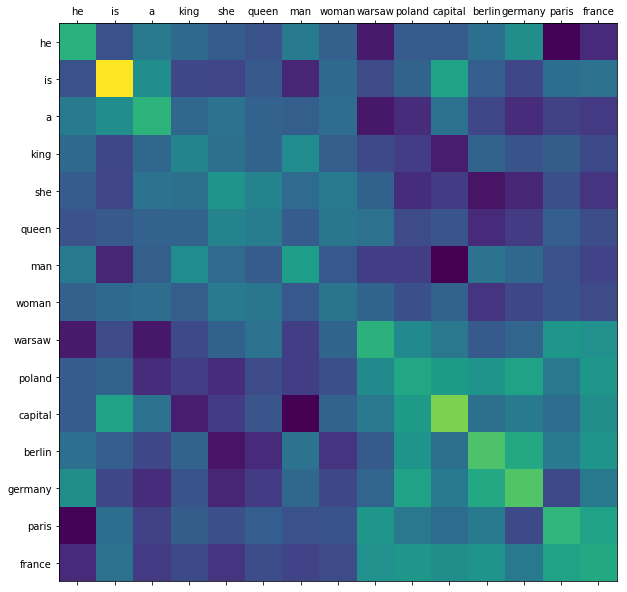

In [79]:
# If i choose W2
# plotting correlation matrix
# lighter color => more related

import matplotlib.pyplot as plt

corr = torch.matmul(W2, W2.permute(1, 0)).detach().numpy()
plt.figure(figsize=(10, 10))
plt.matshow(corr, fignum=1)

groups = list(word2idx.keys())

x_pos = np.arange(len(groups))
plt.xticks(x_pos, groups)

y_pos = np.arange(len(groups))
plt.yticks(y_pos, groups)

plt.show()